<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" /> 
    
    
### <font color='navy'> Modelos no lineales para pronósticos. 

**Nombres:** Xander Gallegos, André Yahir Gonzales.

**Fecha:** 6 de febrero de 2024.

**Expediente** : 737989, XXXXXX.
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: <a href=https://github.com/xagallegos/ProyectoConjunto_XGallegos_AYGonzales>ProyectoConjunto_XGallegos_AYGonzales</a>

# Tarea 2: Clase 5

## Enunciado de tarea

Para ejemplo estudiado en esta clase data WWWUsage.csv probar lo siguiente:
1. Encontrar el mejor modelo ARIMA usando los criterios de AIC, BIC y log-verosimilud, justificando la estructura propuesta.
2. Analizar el efecto de normalizar la serie de tiempo, es decir usar MinMaxScaler para normalizar los datos. Posterior a esto, realizar el mismo precedimiento realizado en clase y encontrar el mejor modelo de ARIMA. Justifique todos los análisis realizados, incluyendo los resultados de las gráficas de ACF y PAC.
3. Investigar la implementación y teoría de los modelos SARIMAX. Además de eso, generar un modelo de pronóstico usando SARIMAX, donde todo el procediemiento anteriormente descrito es implementado, para el siguiente conjunto de datos con estacionalidad:
```
air2 = requests.get('https://www.stata-press.com/data/r12/air2.dta').content
data2 = pd.read_stata(BytesIO(air2))
data2.index = pd.date_range(start=datetime(data2.time[0], 1, 1), periods=len(data2), freq='MS')
```
4. Realizar una predicción de 20 unidades de tiempo en el futuro, tanto para el modelo ARIMA como SARIMA y reportar los resulados en una gráfica donde se puedan observar los datos reales y los datos predichos, cómo en la siguiente gráfica:
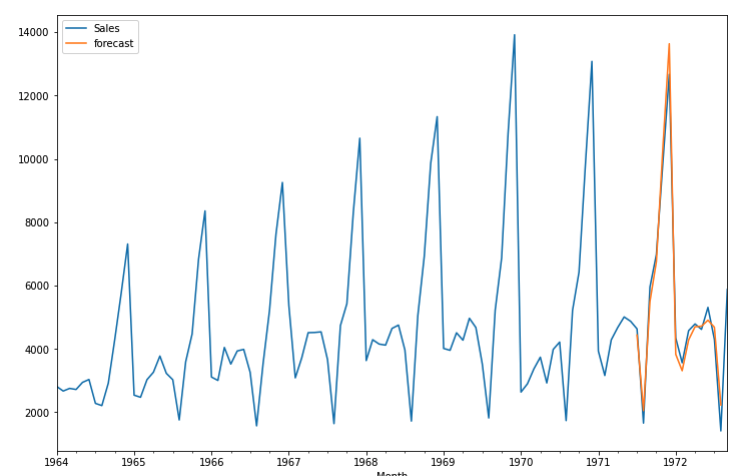

Código de solución estudiante 1: Xander Gallegos

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [72]:
def plot_acf_pacf(data, kwargs=dict()):
    f = plt.figure(figsize=(10,3))

    ax1 = f.add_subplot(121)
    plot_acf(data, zero=False, ax=ax1, **kwargs)

    ax2 = f.add_subplot(122)
    plot_pacf(data, zero=False, ax=ax2, method='ols', **kwargs)

    plt.show()

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
    if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [17]:
# Cargar los datos
file = 'https://raw.githubusercontent.com/odjaramilloz/MPST-2024-I/main/TEMA-1/datasets/WWWusage.csv'

data = pd.read_csv(file, names=['values'], header=0)
data.index = data.index.droplevel()
print(data.shape)
data.head()

(100, 1)


,values
1,88
2,84
3,85
4,85
5,84


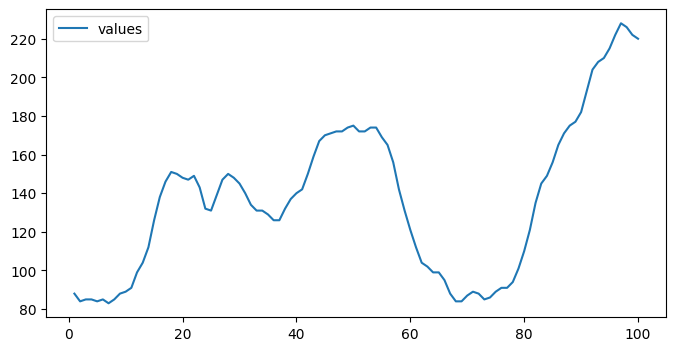

In [6]:
# Visualizar los datos
data.plot(figsize=(8,4))
plt.show()

In [19]:
# Dividir train - test
s = int(len(data) * 0.8)

train = data.iloc[:s]
test = data.iloc[s:]

In [39]:
# Probar estacionalidad
print("\033[97mADF para test\033[00m")
adf_test(train)

diff1_values = train.diff().dropna()
print("\n\033[97mADF para derivada primer orden\033[00m")
adf_test(diff1_values)

diff2_values = train.diff().diff().dropna()
print("\n\033[97mADF para derivada segundo orden\033[00m")
adf_test(diff2_values)

ADF para test
Results of Dickey-Fuller Test:
Test Statistic                 -2.649346
p-value                         0.083221
#Lags Used                      3.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64
Non-stationary

ADF para derivada primer orden
Results of Dickey-Fuller Test:
Test Statistic                 -2.504537
p-value                         0.114374
#Lags Used                      2.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64
Non-stationary

ADF para derivada segundo orden
Results of Dickey-Fuller Test:
Test Statistic                -8.236551e+00
p-value                        5.869012e-13
#Lags Used                     1.000000e+00
Number of Observations Used    7.600000e+01
Critical Value (1%

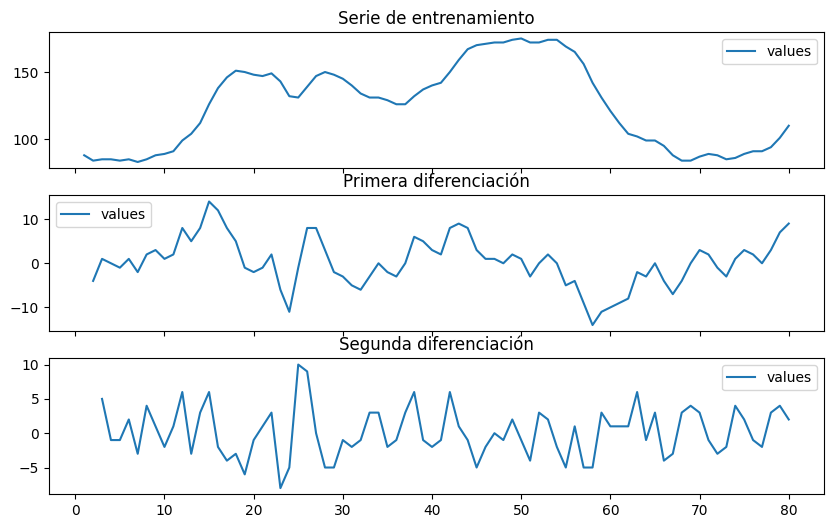

In [65]:
_, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, figsize=(10,6), sharex=True)

train.plot(ax=ax1)
ax1.set_title('Serie de entrenamiento')

diff1_values.plot(ax=ax2)
ax2.set_title('Primera diferenciación')

diff2_values.plot(ax=ax3)
ax3.set_title('Segunda diferenciación')

plt.show()

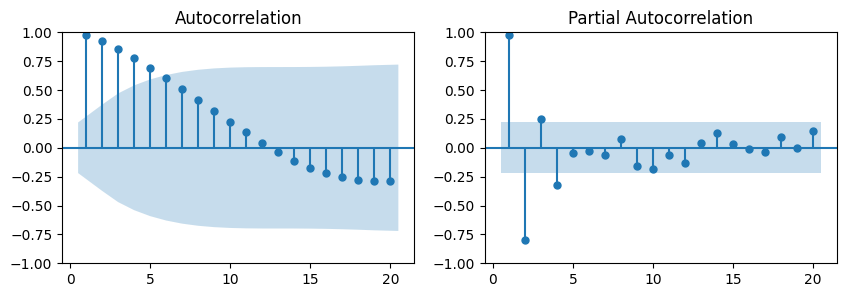

In [74]:
# Graficar ACF y PACF
plot_acf_pacf(train)

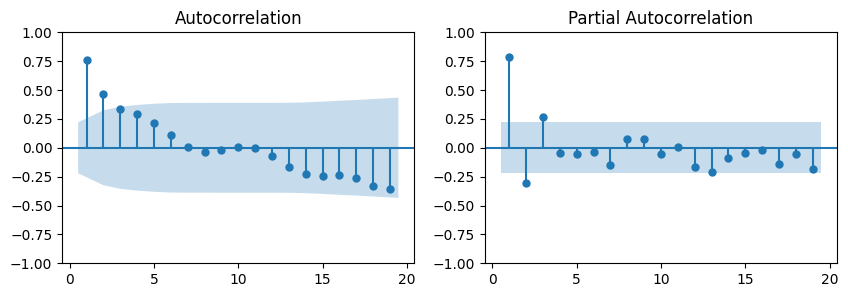

In [75]:
# Primera diferenciación
plot_acf_pacf(diff1_values)

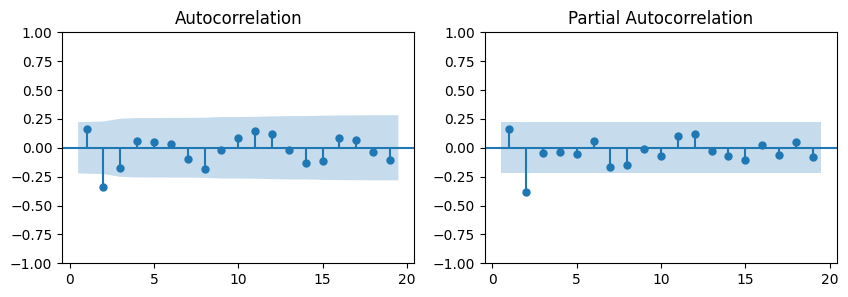

In [76]:
# Segunda diferenciación
plot_acf_pacf(diff2_values)

In [80]:
# Modelo de diferencia primer orden
arima_model1 = ARIMA(train, order=(3,1,4))
model1 = arima_model1.fit()
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                   80
Model:                 ARIMA(3, 1, 4)   Log Likelihood                -200.169
Date:                Tue, 06 Feb 2024   AIC                            416.338
Time:                        13:45:16   BIC                            435.293
Sample:                             0   HQIC                           423.932
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5215      0.285      5.347      0.000       0.964       2.079
ar.L2         -1.0743      0.458     -2.347      0.019      -1.971      -0.177
ar.L3          0.1845      0.291      0.634      0.5

In [81]:
# Modelo de diferencia segundo orden

# Términos de AR
ar = (0, 1)  # (alpha1, alpha2)
# Términos de MA
ma = (0, 1)  # (beta1, beta2)

arima_model2 = ARIMA(data, order=(ar, 2, ma))
model2 = arima_model2.fit()
print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                  100
Model:             ARIMA([2], 2, [2])   Log Likelihood                -256.198
Date:                Tue, 06 Feb 2024   AIC                            518.396
Time:                        13:45:41   BIC                            526.151
Sample:                             0   HQIC                           521.532
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2         -0.2090      0.240     -0.870      0.384      -0.680       0.262
ma.L2         -0.2188      0.238     -0.918      0.359      -0.686       0.248
sigma2        10.8799      1.740      6.253      0.0

Teniendo en cuenta el análisis previo, se probara un modelo ARIMA con los siguientes parámetros:
* $p=3$ debido a los 3 sesgos en la gráfica de autocorrelación parcial.
* $d=1$ a pesar de que la prueba de Dickey Fuller la primera diferenciación salga como no estacionaria, se selecciona la primera diferenciación debido al sesgo negativo inmediato en la grafica de autocorrelación de la segunda diferenciación.
* $q=1$ por el primer sesgo de correlación que sale del rango de significancia en la gráfica de autocorrelación.

In [105]:
# Modelo de diferencia primer orden
arima_model = ARIMA(train, order=(3,1,1))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                   80
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -202.231
Date:                Tue, 06 Feb 2024   AIC                            414.462
Time:                        14:08:43   BIC                            426.309
Sample:                             0   HQIC                           419.209
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0024      0.437      2.295      0.022       0.146       1.858
ar.L2         -0.4731      0.475     -0.997      0.319      -1.403       0.457
ar.L3          0.2333      0.192      1.218      0.2

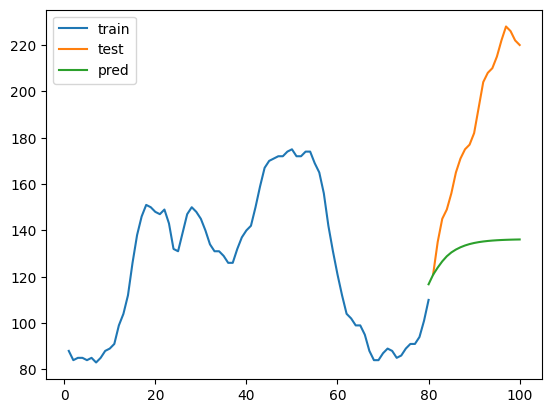

In [106]:
# Predicciones con el modelo ajustado
y_h = model.predict(start=80, end=100, dynamic=False).to_frame()

_, ax = plt.subplots()
train.plot(ax=ax)
test.plot(ax=ax)
y_h.plot(ax=ax)

ax.legend(labels = ['train', 'test', 'pred'])
plt.show()

In [115]:
# Normalizar serie
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

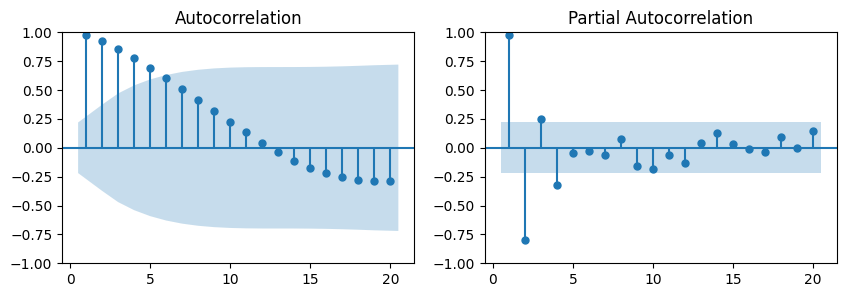

In [116]:
# Graficar ACF y PACF
plot_acf_pacf(scaled_train)

In [117]:
# Probar estacionalidad
print("\033[97mADF para datos escalados\033[00m")
adf_test(scaled_train)

diff1_values = pd.DataFrame(scaled_train).diff().dropna()
print("\n\033[97mADF para derivada primer orden con datos escalados\033[00m")
adf_test(diff1_values)

diff2_values = pd.DataFrame(scaled_train).diff().diff().dropna()
print("\n\033[97mADF para derivada segundo orden con datos escalados\033[00m")
adf_test(diff2_values)

ADF para datos escalados
Results of Dickey-Fuller Test:
Test Statistic                 -2.649346
p-value                         0.083221
#Lags Used                      3.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64
Non-stationary

ADF para derivada primer orden con datos escalados
Results of Dickey-Fuller Test:
Test Statistic                 -2.504537
p-value                         0.114374
#Lags Used                      2.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64
Non-stationary

ADF para derivada segundo orden con datos escalados
Results of Dickey-Fuller Test:
Test Statistic                -8.236551e+00
p-value                        5.869012e-13
#Lags Used                     1.000000e+00
Number of O

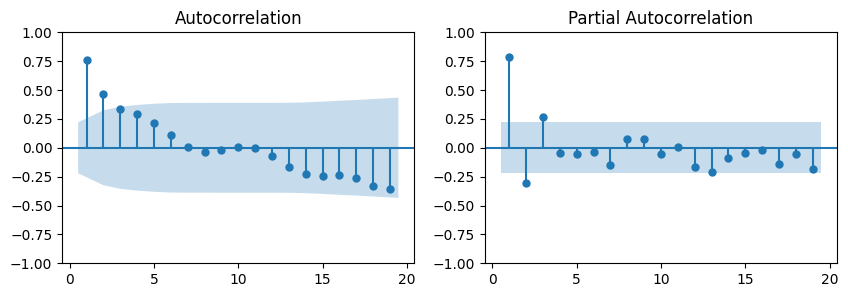

In [101]:
# Primera diferenciación
plot_acf_pacf(diff1_values)

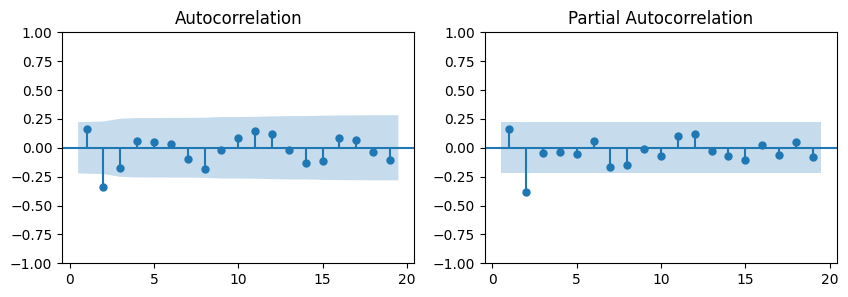

In [102]:
# Segunda diferenciación
plot_acf_pacf(diff2_values)

Las graficas de ACF no muestran una diferencia significativa al haber escalado los datos.

In [118]:
scaled_arima_model = ARIMA(scaled_train, order=(3,1,1))
scaled_model = scaled_arima_model.fit()
print(scaled_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   80
Model:                 ARIMA(3, 1, 1)   Log Likelihood                 154.991
Date:                Tue, 06 Feb 2024   AIC                           -299.981
Time:                        14:15:35   BIC                           -288.134
Sample:                             0   HQIC                          -295.235
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0021      0.437      2.294      0.022       0.146       1.858
ar.L2         -0.4727      0.475     -0.996      0.319      -1.403       0.458
ar.L3          0.2331      0.192      1.216      0.2

Observamos que el modelo mejoró, la log verosimilitud aumentó, mientras que el AIC y BIC disminuyeron.

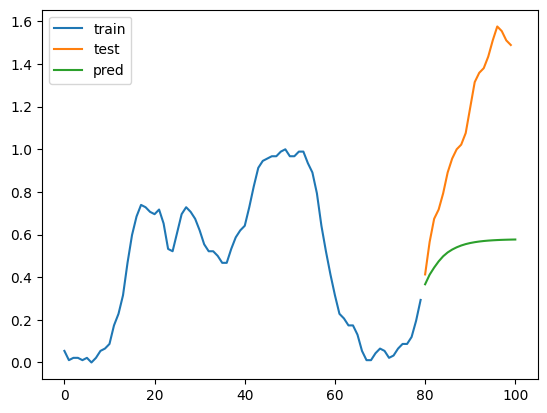

In [124]:
y_h_scaled = scaled_model.predict(start=80, end=100, dynamic=False)

_, ax = plt.subplots()
ax.plot(scaled_train)
ax.plot(list(range(80,100)), scaled_test)
ax.plot(list(range(80,101)), y_h_scaled)

ax.legend(labels = ['train', 'test', 'pred'])
plt.show()

Código de solución estudiante 2

In [ ]:
# Código de solución estudiante 2
.
.
.
.


### Respuesta planteada en el ejercicio usando (markdown)
 La respuesta es .........